In [1]:
# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
import os
os.chdir('..')  # navigate to the root


In [5]:
pwd

'/home/maksym/interlingua'

In [6]:
from normal_transformers.util.util_data import pickle_load_from_file

In [7]:
import pandas as pd

In [8]:
savedir = "assets/multidomain/"

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style('ticks')
sns.set_context("paper", font_scale = 3)

palette = ["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]
sns.set_palette(palette)

# Per-layer Clustering Purity

In [9]:
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
import scipy.stats as ss

from normal_transformers.util.util_data import pickle_load_from_file

In [10]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [11]:
def cluster_purity_confmatrix(confusion_matrix):
    r = []
    for row_num in confusion_matrix:
        r.append(conf_matrix[row_num].max())
    return sum(r) / confusion_matrix.sum().sum()
    

In [12]:
def prepare_reps(hiddens_dict):
    all_reps_prepared = defaultdict(lambda: list())
    all_labels = defaultdict(lambda: list())
    
    for dn, reps_all_layers in hiddens_dict.items():
        for layer_num, reps_layer in enumerate(reps_all_layers):
            all_reps_prepared[layer_num].extend(reps_layer)
            all_labels[layer_num].extend([dn] * len(reps_layer))
    
    for k, v in all_reps_prepared.items():
        all_reps_prepared[k] = np.array(v)
    
    for k, v in all_labels.items():
        all_labels[k] = np.array(v)
    
    return all_reps_prepared, all_labels

In [13]:
domain_names = ['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis']

# EN-ET

BERT

In [138]:
bdir = "experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [139]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.392730769066257
Purity:  0.4807564145284905
Layer 1 corr: 0.44904110395386093
Purity:  0.4942519160279907
Layer 2 corr: 0.6092867889491713
Purity:  0.6424525158280573
Layer 3 corr: 0.6126128122359711
Purity:  0.6452015994668444
Layer 4 corr: 0.6112400349014909
Purity:  0.6443685438187271
Layer 5 corr: 0.6201037453099951
Purity:  0.6494501832722426
Layer 6 corr: 0.5474849085684266
Purity:  0.5563145618127291
Layer 7 corr: 0.5361694721930126
Purity:  0.543402199266911
Layer 8 corr: 0.5533747438896676
Purity:  0.5608963678773742
Layer 9 corr: 0.561762938317396
Purity:  0.5684771742752416
Layer 10 corr: 0.6627539441670462
Purity:  0.6787737420859713
Layer 11 corr: 0.706644235573702
Purity:  0.6966844385204932
Layer 12 corr: 0.6549439806059622
Purity:  0.665361546151283
CPU times: user 7min 13s, sys: 3min 55s, total: 11min 9s
Wall time: 35.9 s


In [141]:
df_corr_ks_bert_en = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

XLM-R

In [142]:
bdir = "experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [143]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.38102690962375485
Purity:  0.4764245251582806
Layer 1 corr: 0.3617083081630277
Purity:  0.44560146617794066
Layer 2 corr: 0.37365730443999035
Purity:  0.4592635788070643
Layer 3 corr: 0.3758594046310442
Purity:  0.45626457847384205
Layer 4 corr: 0.38452287275052716
Purity:  0.46717760746417863
Layer 5 corr: 0.3832042524409476
Purity:  0.46984338553815397
Layer 6 corr: 0.3776695385644564
Purity:  0.4643452182605798
Layer 7 corr: 0.48866577933816757
Purity:  0.5405698100633123
Layer 8 corr: 0.4988736432461752
Purity:  0.5442352549150283
Layer 9 corr: 0.4773097685414721
Purity:  0.5356547817394202
Layer 10 corr: 0.3586753940298106
Purity:  0.43960346551149615
Layer 11 corr: 0.359813724434407
Purity:  0.44535154948350547
Layer 12 corr: 0.36382857417572406
Purity:  0.4580973008997001
CPU times: user 8min 7s, sys: 4min 11s, total: 12min 18s
Wall time: 39.4 s


In [144]:
df_corr_ks_bert = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

In [145]:
df_corr_ks_bert_en['Model'] = ["English BERT Base" for i in range(len(df_corr_ks_bert_en))]
df_corr_ks_bert['Model'] = ["XLM-R Base" for i in range(len(df_corr_ks_bert))]
df_corr_ks_bert_all = pd.concat([df_corr_ks_bert, df_corr_ks_bert_en], ignore_index=True)

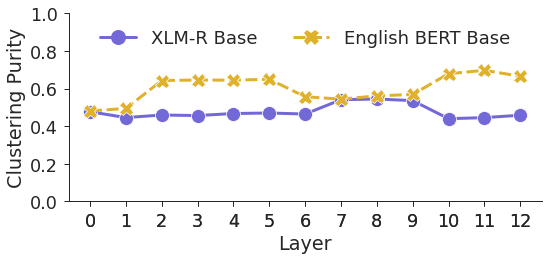

In [150]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(ax=ax, data=df_corr_ks_bert_all, x="Layer", y="Score", hue="Model", style="Model", 
            markers=True, dashes=True, lw=3, markersize=14)

ax.set(xlabel='Layer', ylabel='Clustering Purity' )
ax.set(xticks=df_corr_ks_bert_all.Layer.values)

handles, labels = ax.get_legend_handles_labels()
lgnd  = ax.legend(fontsize=18,
            ncol=2, loc=9)
lgnd.legendHandles[0]._legmarker.set_markersize(15)
lgnd.legendHandles[1]._legmarker.set_markersize(15)
lgnd.legendHandles[0].set_linewidth(3)
lgnd.legendHandles[1].set_linewidth(3)

plt.ylim(0, 1)
sns.despine(right = True)
fig.tight_layout()
plt.show()

In [151]:
fig.savefig(f"{savedir}/clust_purity-layers-en_et-bert.pdf", bbox_inches='tight')

## NMT 

chkp 60

In [152]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [153]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.4710914999380308
Purity:  0.48975341552815727
Layer 1 corr: 0.5996320000398796
Purity:  0.6259580139953349
Layer 2 corr: 0.7440972350310012
Purity:  0.7957347550816395
Layer 3 corr: 0.76337833222007
Purity:  0.8095634788403865
Layer 4 corr: 0.7411966577954152
Purity:  0.7964845051649451
Layer 5 corr: 0.6174078202745019
Purity:  0.6142952349216928
Layer 6 corr: 0.578700215347345
Purity:  0.6430356547817394
Layer 7 corr: 0.24144286224096861
Purity:  0.37320893035654784
Layer 8 corr: 0.3413460286912535
Purity:  0.43210596467844054
Layer 9 corr: 0.34298368158112114
Purity:  0.43577140953015664
Layer 10 corr: 0.3664342944030517
Purity:  0.44401866044651783
Layer 11 corr: 0.3655495908904168
Purity:  0.4374375208263912
Layer 12 corr: 0.449490602054893
Purity:  0.5082472509163612
CPU times: user 6min 42s, sys: 3min 4s, total: 9min 47s
Wall time: 31.9 s


In [154]:
df_corr_ks_nmt_60 = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

chckp 1

In [155]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [156]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.19825138512945278
Purity:  0.34638453848717093
Layer 1 corr: 0.835150579070241
Purity:  0.8739586804398534
Layer 2 corr: 0.8580424127074515
Purity:  0.8910363212262579
Layer 3 corr: 0.8579185086642296
Purity:  0.8903698767077641
Layer 4 corr: 0.8679819375779584
Purity:  0.8985338220593135
Layer 5 corr: 0.8684858863743865
Purity:  0.8992835721426191
Layer 6 corr: 0.8823695099658075
Purity:  0.9106131289570143
Layer 7 corr: 0.201892671839616
Purity:  0.3520493168943685
Layer 8 corr: 0.322930291829336
Purity:  0.42827390869710097
Layer 9 corr: 0.3185901054487144
Purity:  0.42819060313228924
Layer 10 corr: 0.3497039872316098
Purity:  0.44826724425191605
Layer 11 corr: 0.37684134981909456
Purity:  0.47150949683438853
Layer 12 corr: 0.6334751868338613
Purity:  0.6351216261246251
CPU times: user 6min 49s, sys: 3min 9s, total: 9min 59s
Wall time: 32.6 s


In [157]:
df_corr_ks_nmt_1 = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

In [158]:
df_corr_ks_nmt_60['Model'] = ["NMT Checkpoint 60" for i in range(len(df_corr_ks_nmt_60))]
df_corr_ks_nmt_1['Model'] = ["NMT Checkpoint 1" for i in range(len(df_corr_ks_nmt_1))]
df_corr_ks_nmt = pd.concat([df_corr_ks_nmt_60, df_corr_ks_nmt_1], ignore_index=True)

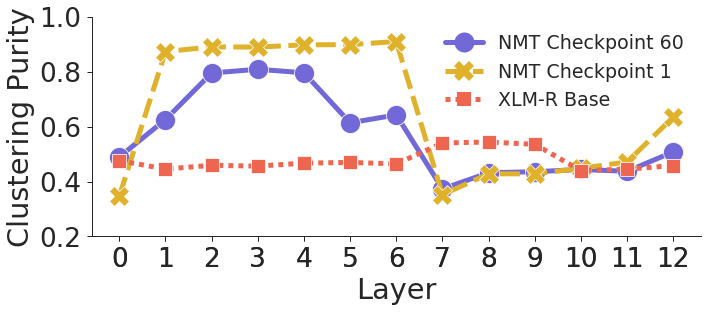

In [226]:
fig, ax = plt.subplots(figsize=(10.5, 5))
sns.lineplot(ax=ax, data=pd.concat([df_corr_ks_nmt, df_corr_ks_bert], ignore_index=True), x="Layer", y="Score", hue="Model", style="Model", 
            markers=True, dashes=True, lw=5, markersize=20)

ax.set(xlabel='Layer', ylabel='Clustering Purity' )
ax.set(xticks=df_corr_ks_nmt.Layer.values)

handles, labels = ax.get_legend_handles_labels()

# lgnd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),
#           ncol=3, fontsize=18, columnspacing=0.8, handletextpad=0.3)

lgnd = ax.legend(fontsize=19, loc='upper right')

for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(20)
    lh.set_linewidth(5)

plt.ylim(0.2, 1)
sns.despine(right = True)
fig.tight_layout()
plt.show()

In [227]:
fig.savefig(f"{savedir}/clust_purity-layers-en_et-all.pdf", bbox_inches='tight')

# DE-EN

## BERTs

mono

In [ ]:
bdir = "experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [ ]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.4102140668360326
Purity:  0.4396867710763079
Layer 1 corr: 0.6385474741849089
Purity:  0.6673608797067644
Layer 2 corr: 0.642759586749648
Purity:  0.6667777407530823
Layer 3 corr: 0.6570917721653742
Purity:  0.6724425191602799
Layer 4 corr: 0.6727169829493602
Purity:  0.6830223258913696
Layer 5 corr: 0.6878590294358944
Purity:  0.6912695768077307
Layer 6 corr: 0.6991189274824208
Purity:  0.6966011329556815
Layer 7 corr: 0.7043218598470282
Purity:  0.699516827724092
Layer 8 corr: 0.6577697517104534
Purity:  0.6586971009663446
Layer 9 corr: 0.6739979243392286
Purity:  0.6839386871042986
Layer 10 corr: 0.6701225998888072
Purity:  0.6934355214928357
Layer 11 corr: 0.7130018910476276
Purity:  0.7086804398533822
Layer 12 corr: 0.7260781646556752
Purity:  0.7180939686771076
CPU times: user 7min 41s, sys: 4min 20s, total: 12min 1s
Wall time: 38.7 s


In [ ]:
df_corr_ks_bert_de = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

xlmr

In [ ]:
bdir = "experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [ ]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.46064575888750814
Purity:  0.5209096967677441
Layer 1 corr: 0.40826785196457493
Purity:  0.4748417194268577
Layer 2 corr: 0.4163469123960701
Purity:  0.4750916361212929
Layer 3 corr: 0.4050416546945054
Purity:  0.475674775074975
Layer 4 corr: 0.4199930811689781
Purity:  0.4786737754081973
Layer 5 corr: 0.41708698911166625
Purity:  0.4810063312229257
Layer 6 corr: 0.4256918829179741
Purity:  0.47692435854715093
Layer 7 corr: 0.48282051541247983
Purity:  0.4955014995001666
Layer 8 corr: 0.48462785006018955
Purity:  0.4979173608797068
Layer 9 corr: 0.5381585416122212
Purity:  0.5917194268577141
Layer 10 corr: 0.4055069777758234
Purity:  0.4677607464178607
Layer 11 corr: 0.4108360463406002
Purity:  0.4761746084638454
Layer 12 corr: 0.40418187125633387
Purity:  0.45959680106631123
CPU times: user 8min 10s, sys: 3min 54s, total: 12min 4s
Wall time: 38.8 s


In [ ]:
df_corr_ks_xlmr = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

In [ ]:
df_corr_ks_bert_de['Model'] = ["German BERT Base" for i in range(len(df_corr_ks_bert_de))]
df_corr_ks_xlmr['Model'] = ["XLM-R Base" for i in range(len(df_corr_ks_xlmr))]
df_corr_ks_bert_all = pd.concat([df_corr_ks_bert_de, df_corr_ks_xlmr], ignore_index=True)

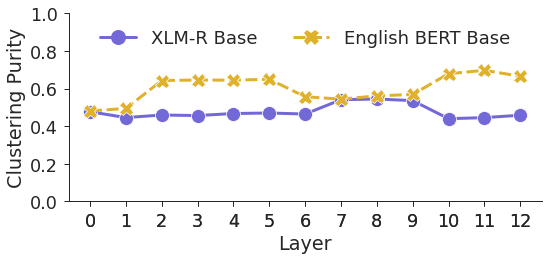

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(ax=ax, data=df_corr_ks_bert_all, x="Layer", y="Score", hue="Model", style="Model", 
            markers=True, dashes=True, lw=3, markersize=14)

ax.set(xlabel='Layer', ylabel='Clustering Purity' )
ax.set(xticks=df_corr_ks_bert_all.Layer.values)

handles, labels = ax.get_legend_handles_labels()
lgnd  = ax.legend(fontsize=18,
            ncol=2, loc=9)
lgnd.legendHandles[0]._legmarker.set_markersize(15)
lgnd.legendHandles[1]._legmarker.set_markersize(15)
lgnd.legendHandles[0].set_linewidth(3)
lgnd.legendHandles[1].set_linewidth(3)

plt.ylim(0, 1)
sns.despine(right = True)
fig.tight_layout()
plt.show()

In [ ]:
fig.savefig(f"{savedir}/clust_purity-layers-de_en-bert.pdf", bbox_inches='tight')

# Confusion Tables & Clustering Purity

In [31]:
import itertools
domain_names = ["Europarl", "OpenSubtitles", "EMEA", "JRC-Acquis"]
clust_names = ['0', '1', '2', '3']

clus_corp_pairs = list(itertools.product(domain_names, clust_names))

In [77]:
def cluster_purity(df):
    r = []
    for cn in clust_names:
        r.append(df[df.cluster_label == cn].max()['count'])
    return round((sum(r) / df['count'].sum()) * 100, 2)

In [78]:
def get_domain(fn, domain_names):
    for d in domain_names:
        if d in fn:
            return d

In [79]:
def compose_labels_pairs_dfs(bp):
    clust_pathes = {}
    clust_pathes["nmt-sent"] = f"{bp}/nmt-clusters-sent"
    clust_pathes["nmt-doc"] = f"{bp}/nmt-clusters-doc"
    clust_pathes["bert-sent"] = f"{bp}/bert-clusters-sent"
    clust_pathes["bert-doc"] = f"{bp}/bert-clusters-doc"


    clust_fnames = {}
    for k, v in clust_pathes.items():
        clust_fnames[k] = fnames = [f for f in next(os.walk(v))[2] if split in f]

    #
    labels_pairs = {}
    for k, v in clust_fnames.items():
        clust_labels = []
        corpus_labels = []
        labels_pairs[k] = []

        for fn in v:
            d = get_domain(fn, domain_names)        

            full_fn = f"{clust_pathes[k]}/{fn}"
            with open(full_fn, "r") as f:
                curr_clust_labels = [l.strip() for l in f.readlines()]
                curr_corpus_labels = [d for i in range(len(curr_clust_labels))]
            clust_labels.extend(curr_clust_labels)
            corpus_labels.extend(curr_corpus_labels)

        labels_pairs[k] = (corpus_labels, clust_labels)

    #
    print("Total counts")
    labels_pairs_dfs = {}
    for k, v in labels_pairs.items():
        print(k, len(v[0]))
        df = pd.DataFrame(
            {'corpus_label': v[0],
             'cluster_label': v[1],
            }).groupby(['corpus_label','cluster_label']).size().reset_index().rename(columns={0:'count'})
        #df['Type'] = [str(k) for i in r
        labels_pairs_dfs[k] = df
        
        
    # Fill NAs
    for k, df in labels_pairs_dfs.items():
        for p in clus_corp_pairs:
            dl, cl = p[0], p[1]
            missing = len(df[(df.corpus_label == dl) & (df.cluster_label == cl)]) == 0

            if missing:
                labels_pairs_dfs[k] = labels_pairs_dfs[k].append({'corpus_label':dl, 'cluster_label':cl, 'count':0}, ignore_index=True)

    return labels_pairs_dfs

## EN-ET

SPLIT: train

Total counts
nmt-sent 1911602
nmt-doc 1911602
bert-sent 1911602
bert-doc 1911602

Clustering purity train:
nmt-sent: 67.21
nmt-doc: 99.61
bert-sent: 53.47
bert-doc: 85.77


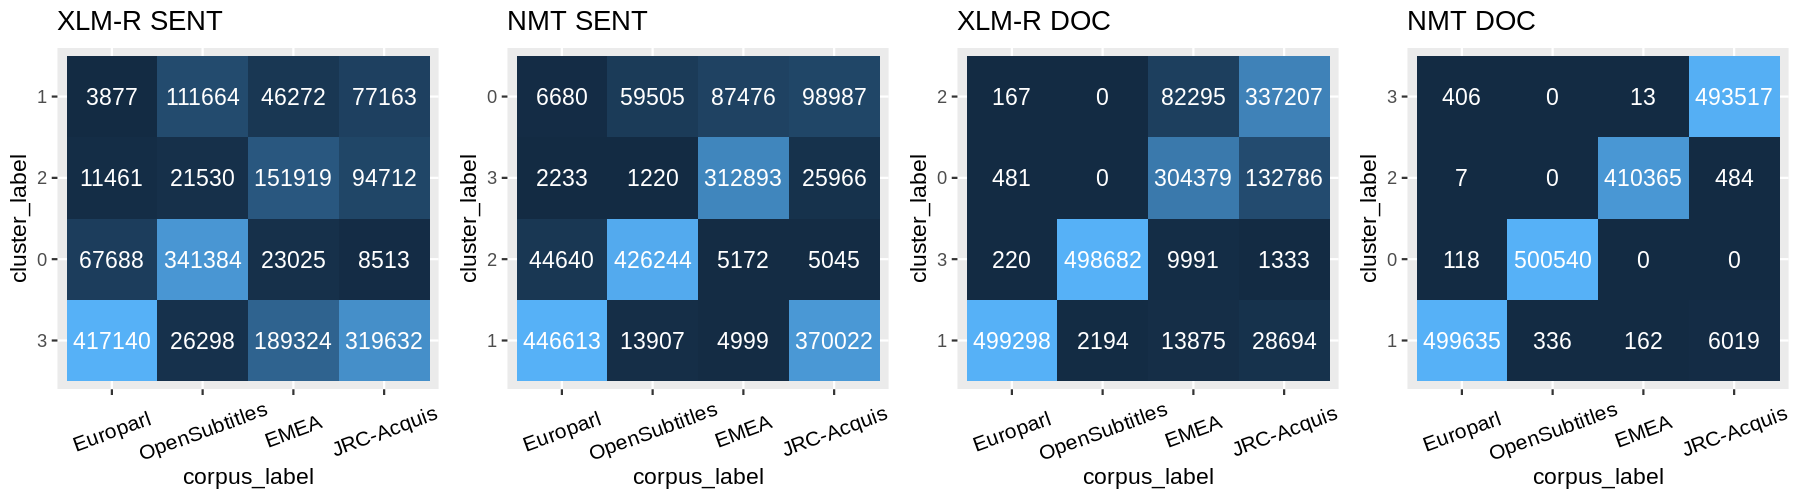

SPLIT: dev-cl

Total counts
nmt-sent 13113
nmt-doc 13113
bert-sent 13113
bert-doc 13113

Clustering purity dev-cl:
nmt-sent: 72.56
nmt-doc: 100.0
bert-sent: 52.9
bert-doc: 72.89


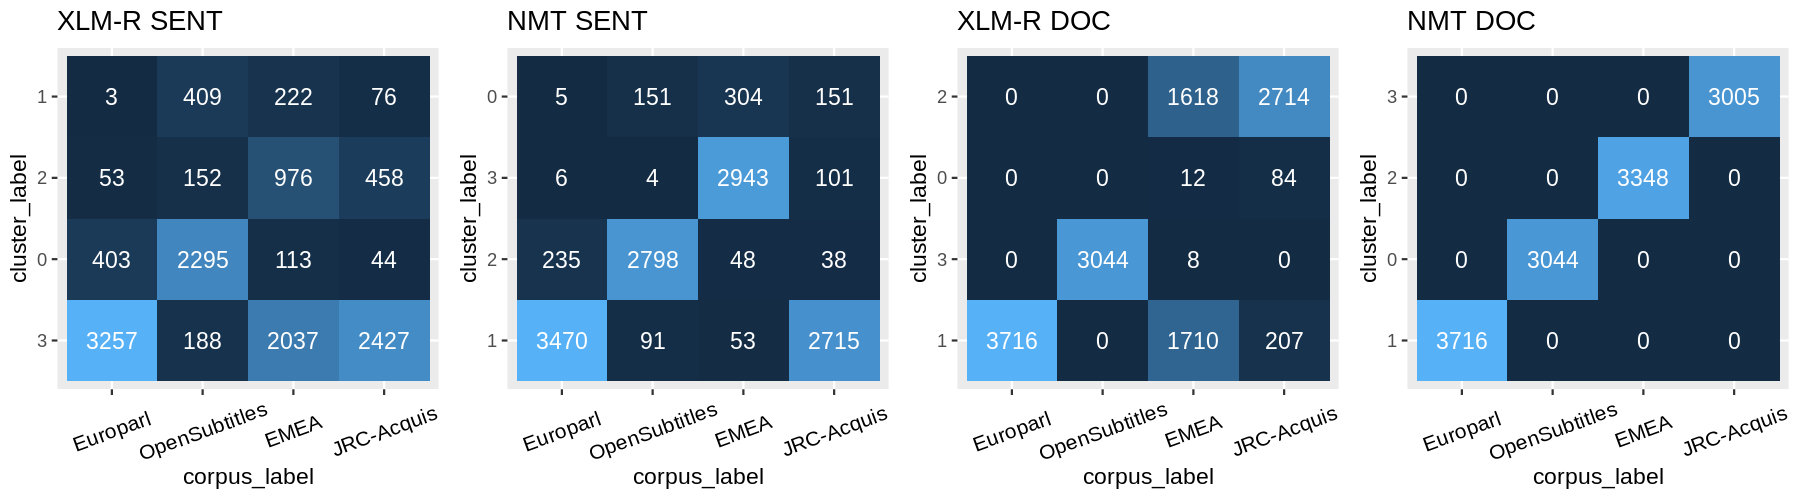

SPLIT: test

Total counts
nmt-sent 12697
nmt-doc 12697
bert-sent 12697
bert-doc 12697

Clustering purity test:
nmt-sent: 70.7
nmt-doc: 99.1
bert-sent: 50.07
bert-doc: 70.14


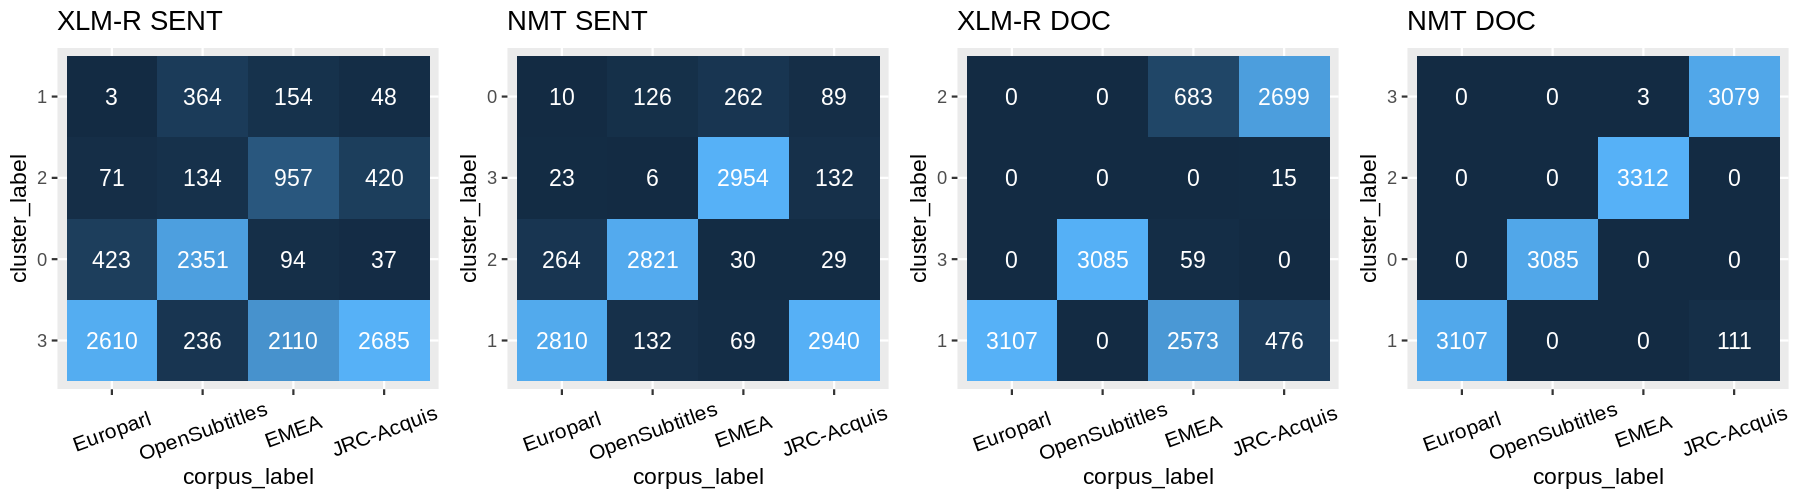

In [80]:
lpair = "en-et"

for split in ["train", "dev-cl", "test"]:
    print(f"SPLIT: {split}\n")

    bp = "/home/maksym/normal-transformers/experiments/multidomain/automatic_domains/clusters-multidomain/clusters_en-et"
    labels_pairs_dfs = compose_labels_pairs_dfs(bp)

    print(f"\nClustering purity {split}:")
    for k, df in labels_pairs_dfs.items():
        cp = cluster_purity(df)
        print(f"{k}: {cp}")

    # Plot
    key = 'nmt-sent'
    title = "NMT SENT"

    cat_clust_labels = CategoricalDtype(categories=['1', '2', '3', '0'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)
    
    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap1 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))



    key = 'nmt-doc'
    title = "NMT DOC"

    cat_clust_labels = CategoricalDtype(categories=['1', '0', '2', '3'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap2 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-sent'
    title = "XLM-R SENT"

    cat_clust_labels = CategoricalDtype(categories=['3', '0', '2', '1'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap3 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-doc'
    title = "XLM-R DOC"

    cat_clust_labels = CategoricalDtype(categories=['1', '3', '0', '2'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap4 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20)) \

    with grdevices.render_to_bytesio(grdevices.png, width=1800, height=500, res=150) as img:
        pp = cowplot.plot_grid(heatmap3, heatmap1, heatmap4, heatmap2, rows=1)
        pp.plot() 
    display(Image(data=img.getvalue(), format='png', embed=True))
    
    pp.save(f"conf_table-{lpair}-{split}.pdf", width=29.7, height=8.25, units="cm", device="pdf", dpi=300, path=savedir)
    

## DE-EN

SPLIT: train

Total counts
nmt-sent 2002484
nmt-doc 2002484
bert-sent 2002484
bert-doc 2002484

Clustering purity train:
nmt-sent: 66.32
nmt-doc: 99.21
bert-sent: 44.04
bert-doc: 97.64


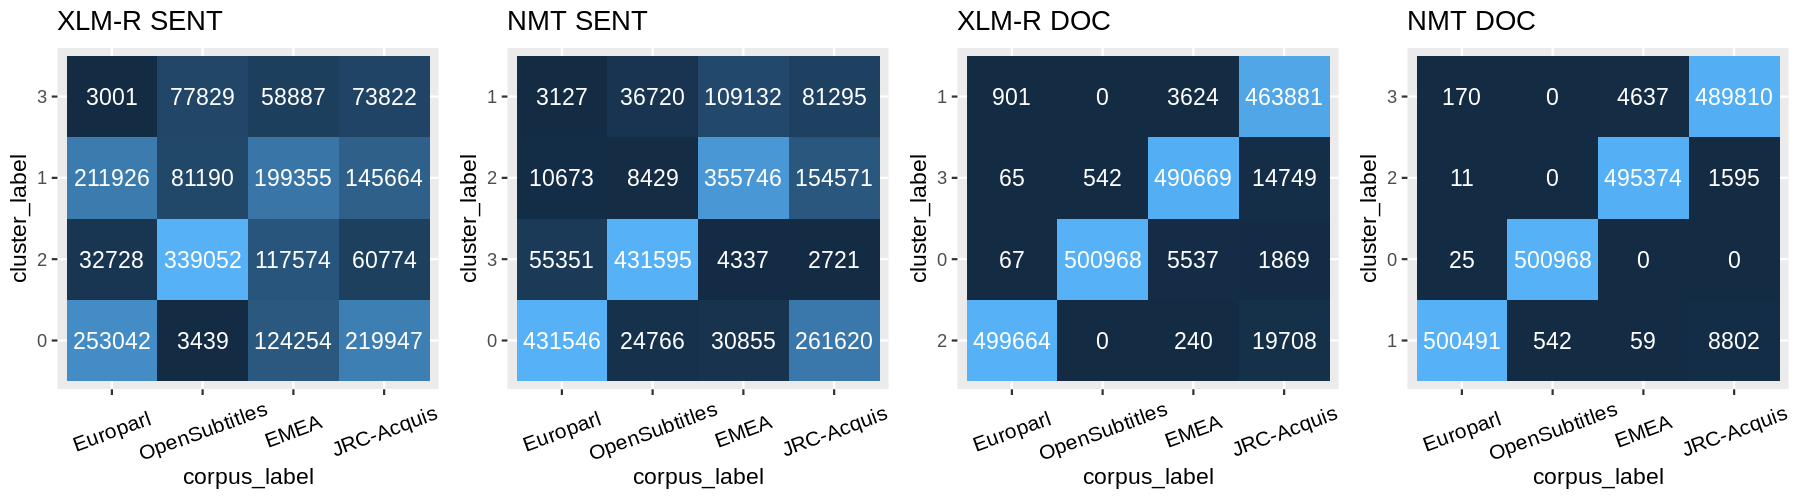

SPLIT: dev-cl

Total counts
nmt-sent 14384
nmt-doc 14384
bert-sent 14384
bert-doc 14384

Clustering purity dev-cl:
nmt-sent: 70.02
nmt-doc: 97.58
bert-sent: 49.2
bert-doc: 91.74


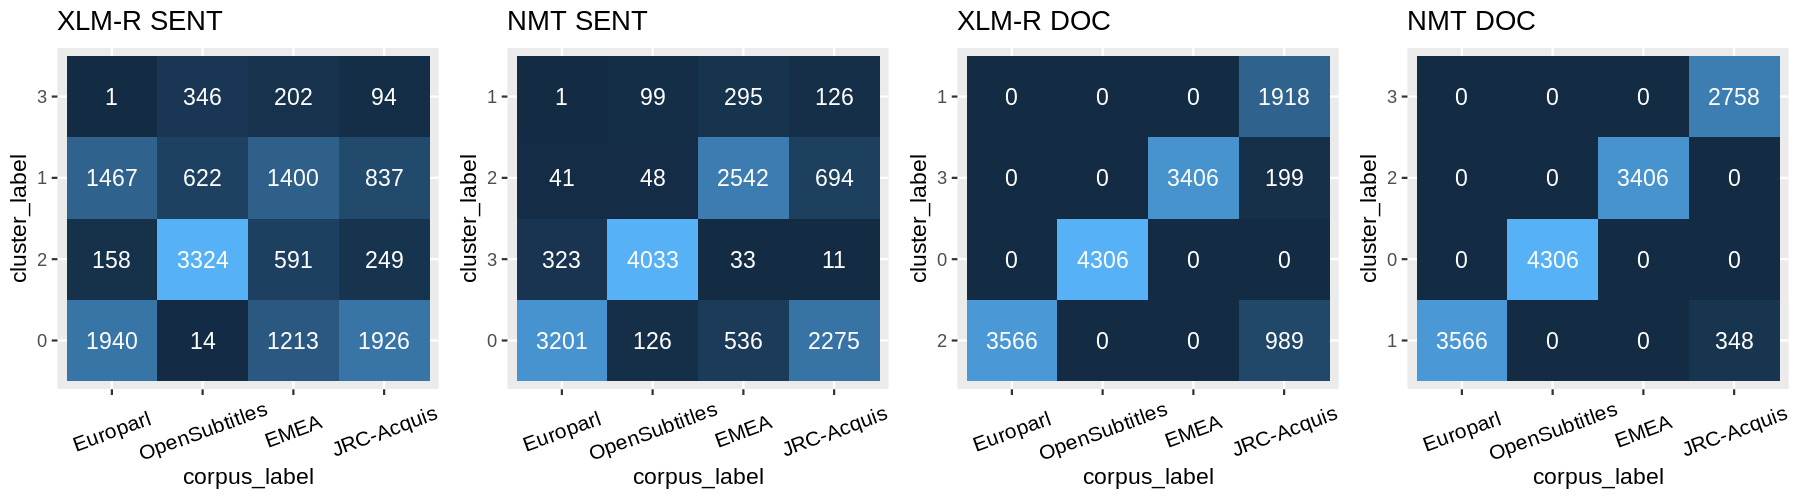

SPLIT: test

Total counts
nmt-sent 15244
nmt-doc 15244
bert-sent 15244
bert-doc 15244

Clustering purity test:
nmt-sent: 72.28
nmt-doc: 99.78
bert-sent: 48.6
bert-doc: 95.23


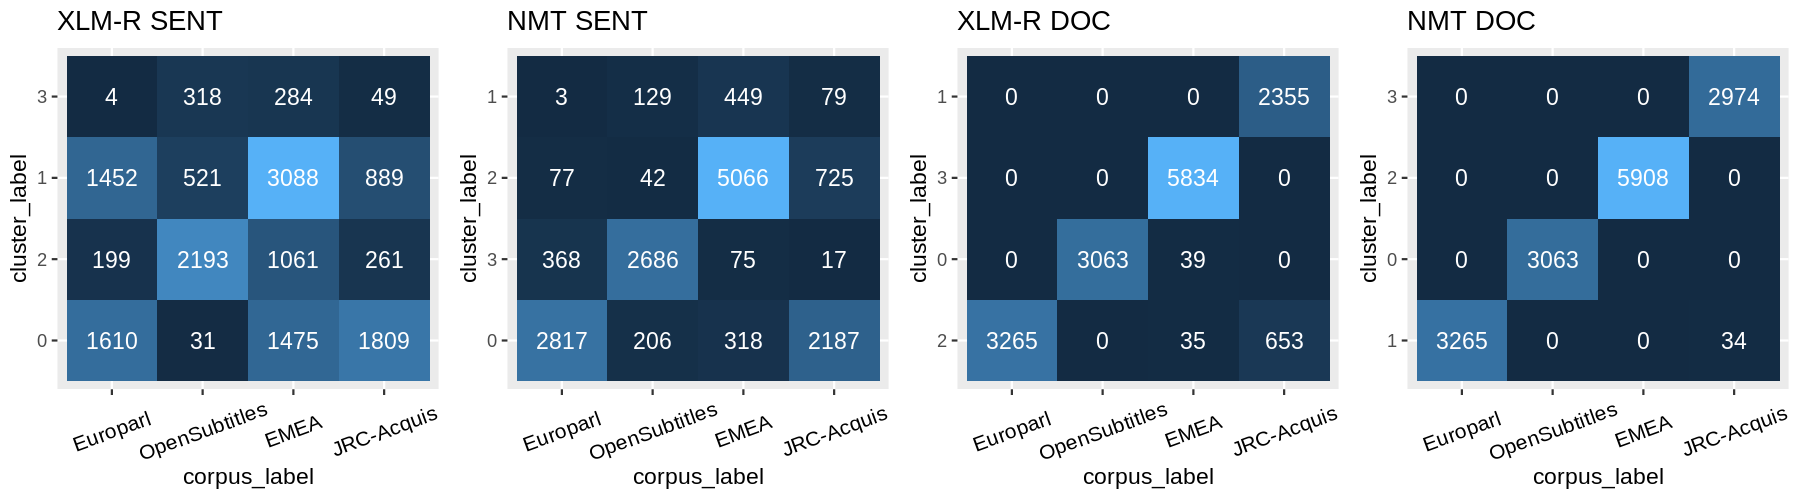

In [81]:
lpair = "de-en"

for split in ["train", "dev-cl", "test"]:
    print(f"SPLIT: {split}\n")

    bp = "/home/maksym/normal-transformers/experiments/multidomain/automatic_domains/clusters-multidomain/clusters_de-en"
    labels_pairs_dfs = compose_labels_pairs_dfs(bp)

    print(f"\nClustering purity {split}:")
    for k, df in labels_pairs_dfs.items():
        cp = cluster_purity(df)
        print(f"{k}: {cp}")

    # Plot
    key = 'nmt-sent'
    title = "NMT SENT"

    cat_clust_labels = CategoricalDtype(categories=['0', '3', '2', '1'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap1 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))



    key = 'nmt-doc'
    title = "NMT DOC"

    cat_clust_labels = CategoricalDtype(categories=['1', '0', '2', '3'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap2 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-sent'
    title = "XLM-R SENT"

    
    cat_clust_labels = CategoricalDtype(categories=['0', '2', '1', '3'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap3 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-doc'
    title = "XLM-R DOC"

    cat_clust_labels = CategoricalDtype(categories=['2', '0', '3', '1'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"

    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap4 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))





    with grdevices.render_to_bytesio(grdevices.png, width=1800, height=500, res=150) as img:
        pp = cowplot.plot_grid(heatmap3, heatmap1, heatmap4, heatmap2, rows=1) 
        pp.plot() 
    display(Image(data=img.getvalue(), format='png', embed=True))
    
    pp.save(f"conf_table-{lpair}-{split}.pdf", width=29.7, height=8.25, units="cm", device="pdf", dpi=300, path=savedir)


# Stats

In [82]:
# bert doc
# 437646 sents, 8669070 tokens
# 544061 sents, 16185004 tokens
# 419669 sents, 11227990 tokens
# 510226 sents, 5367675 tokens

# bert sent
# 440610 sents, 4887451 tokens
# 238976 sents, 972809 tokens
# 279622 sents, 3074726 tokens
# 952394 sents, 32514753 tokens

# nmt doc
# 500658 sents, 5329120 tokens
# 506152 sents, 15149366 tokens
# 410856 sents, 7617303 tokens
# 493936 sents, 13353950 tokens

# nmt sent
# 252651 sents, 1034957 tokens
# 835541 sents, 27815748 tokens
# 481098 sents, 5238259 tokens
# 342312 sents, 7360775 tokens

# rand
# 478097 sents, 10381779 tokens
# 478346 sents, 10367107 tokens
# 477660 sents, 10360378 tokens
# 477499 sents, 10340475 tokens

In [106]:
bs =  [(440610 , 4887451), 
 (238976 , 972809), 
 (279622 , 3074726), 
 (952394 , 32514753)] 

for p in bs:
    print(round(p[1] / p[0]))

11
4
11
34


In [107]:
bd = [(437646, 8669070), (544061, 16185004), (419669, 11227990), (510226, 5367675)]

for p in bd:
    print(round(p[1] / p[0]))

20
30
27
11


In [108]:
ns = [(252651 , 1034957 ),
(835541 , 27815748),
(481098 , 5238259 ),
(342312 , 7360775 )]

for p in ns:
    print(round(p[1] / p[0]))

4
33
11
22


In [109]:
nd = [(500658 , 5329120),
( 506152 , 15149366),
( 410856 , 7617303), 
( 493936 , 13353950)]

for p in nd:
    print(round(p[1] / p[0]))

11
30
19
27


In [110]:
rand = [(478097, 10381779),
(478346, 10367107),
(477660, 10360378),
(477499, 10340475)]

for p in rand:
    print(round(p[1] / p[0]))

22
22
22
22


In [ ]:
# corpus id DE-EN
# 500070 sents, 9558350 tokens
#  500697 sents, 15637061 tokens
# 500207 sents, 13197439 tokens
# 501510 sents, 5024610 

In [111]:
corpid = [(500070, 9558350 ),
(500697, 15637061),
(500207 , 13197439),
(501510 , 5024610 )]

for p in corpid:
    print(round(p[1] / p[0]))

19
31
26
10


In [114]:
# EN-ET CORPID

corpid = [(410540+410540,   7204084+6805718),
   (500166 + 500166,  14453173 + 12452392),
   (500020 + 500020,  13046636 + 10504164),
   (500876 + 500876,   4834243 + 4205176)]

for p in corpid:
    print(round(p[1] / p[0]))

17
27
24
9


# Misc

In [238]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [239]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=20).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    corr_ks.append(corr_k)

    print(f"Layer {l} corr: {corr_k}")
    print(conf_matrix)

Layer 0 corr: 0.4777677017789821
col_0             0     1     2    3
row_0                               
EMEA              0  2509   689  150
Europarl          6  1813  1553  344
JRC-Acquis        0  1466  1082  457
OpenSubtitles  2019   972    46    7
Layer 1 corr: 0.596244246355513
col_0             0     1    2     3
row_0                               
EMEA           2012   344  918    74
Europarl        118   694   36  2868
JRC-Acquis      308   141  471  2085
OpenSubtitles    82  2616  346     0
Layer 2 corr: 0.7415241035037464
col_0             0     1     2     3
row_0                                
EMEA            758    53    40  2497
Europarl        637   220  2822    37
JRC-Acquis      361  2105   253   286
OpenSubtitles  2957     0    27    60
Layer 3 corr: 0.7611968255131059
col_0             0     1     2     3
row_0                                
EMEA             28    39   722  2559
Europarl       2876   207   603    30
JRC-Acquis      238  2155   389   223
OpenSub

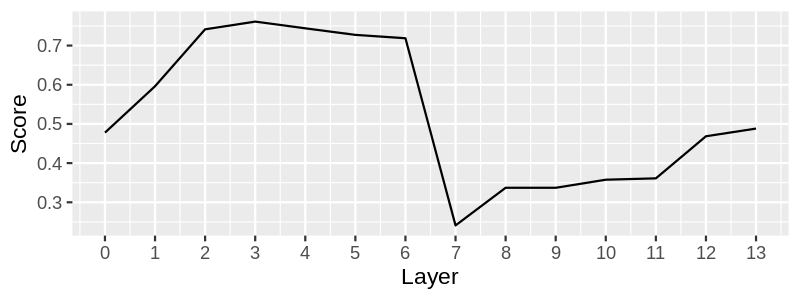

In [241]:
df_corr_ks_nmt = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

with grdevices.render_to_bytesio(grdevices.png, width=800, height=300, res=150) as img:
    gp = ggplot2.ggplot(df_corr_ks_nmt)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.geom_line() \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_nmt["Layer"], breaks = df_corr_ks_nmt["Layer"]) 
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))